In [1]:
import sys

print(sys.path)
sys.path.append("/home/momentino/GarbageDetectionAndSegmentation")

['/home/momentino/GarbageDetectionAndSegmentation/notebooks', '/usr/lib64/python310.zip', '/usr/lib64/python3.10', '/usr/lib64/python3.10/lib-dynload', '', '/home/momentino/.local/lib/python3.10/site-packages', '/usr/lib64/python3.10/site-packages', '/usr/lib/python3.10/site-packages']


In [2]:
import imageio.v3 as iio
import joblib

import random as rand
import numpy as np 
import cv2
import glob
import time

import matplotlib.pyplot as plt
%matplotlib inline

from utils import convert, show_images, put_boxes, box_boundaries
from featuresourcer import FeatureSourcer
from binaryclassifier import BinaryClassifier
from slider import Slider
from heatmap import HeatMap 
from segmenter import WatershedSegmenter

In [3]:
svc = joblib.load('svc.pkl')
scaler = joblib.load('scaler.pkl')

sourcer_params = {
  'color_model': 'hls',                # hls, hsv, yuv, ycrcb
  'bounding_box_h': 48,             #
  'bounding_box_w': 64,
  'number_of_orientations': 12,        # 6 - 12
  'pixels_per_cell': 8,               # 8, 16
  'cells_per_block': 2,                # 1, 2
  'do_transform_sqrt': True
}

cls = BinaryClassifier(svc, scaler)
src = FeatureSourcer(sourcer_params, iio.imread("/home/momentino/TACO/data/batch_13/000082.jpg"))
slider = Slider(sourcer = src, classifier = cls, increment = 32)

img1 = iio.imread("/home/momentino/TACO/data/batch_13/000082.jpg")

heatmap = HeatMap(frame = img1, thresh = 6, memory = 4)


In [4]:
def heatmap_test(image, this_heatmap):
  this_heatmap.reset()

  bounding_boxes = slider.locate(image = image)
  this_heatmap.update(bounding_boxes)
  this_heatmap.show(image)

iteration  0
image dim (4160, 3120, 3)
STEP SIZE  32
iteration  1
image dim (2773, 2080, 3)
STEP SIZE  21
iteration  2
image dim (1847, 1386, 3)
STEP SIZE  14
iteration  3
image dim (1231, 924, 3)
STEP SIZE  9
iteration  4
image dim (820, 616, 3)
STEP SIZE  6
iteration  5
image dim (545, 410, 3)
STEP SIZE  4
iteration  6
image dim (362, 273, 3)
STEP SIZE  2
iteration  7
image dim (241, 182, 3)
STEP SIZE  1
iteration  8
image dim (160, 121, 3)
STEP SIZE  1
iteration  9
image dim (105, 80, 3)
STEP SIZE  1
iteration  10
image dim (69, 53, 3)
STEP SIZE  1
iteration  11
image dim (45, 35, 3)
STEP SIZE  1


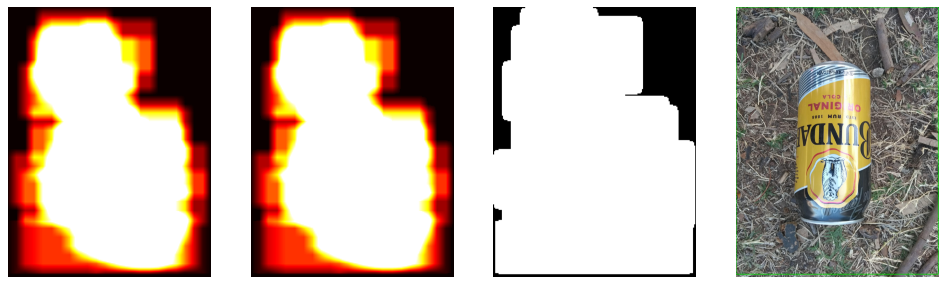

In [5]:
heatmap_test(img1, heatmap)

In [6]:
object_proposals = heatmap.get_final_bounding_boxes()
print(object_proposals)

[((0, 0), (3108, 4116))]


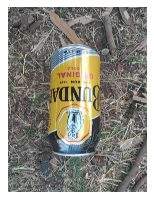

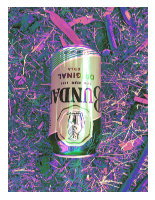

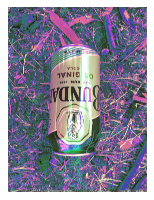

In [7]:
segmenter = WatershedSegmenter(img1, object_proposals)
show_images([img1], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
segmented_object_proposals = segmenter.segment_object_proposals()
show_images([segmented_object_proposals[0]], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
final_image= segmenter.build_final_image(segmented_object_proposals)
show_images([final_image], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)

In [8]:

src = FeatureSourcer(sourcer_params, iio.imread("/home/momentino/TACO/data/batch_13/000082.jpg"))
slider = Slider(sourcer = src, classifier = cls, increment = 32)

img1 = iio.imread("/home/momentino/TACO/data/batch_13/000082.jpg")

heatmap = HeatMap(frame = img1, thresh = 6, memory = 4)

iteration  0
image dim (4160, 3120, 3)
STEP SIZE  32
iteration  1
image dim (2773, 2080, 3)
STEP SIZE  21
iteration  2
image dim (1847, 1386, 3)
STEP SIZE  14
iteration  3
image dim (1231, 924, 3)
STEP SIZE  9
iteration  4
image dim (820, 616, 3)
STEP SIZE  6
iteration  5
image dim (545, 410, 3)
STEP SIZE  4
iteration  6
image dim (362, 273, 3)
STEP SIZE  2
iteration  7
image dim (241, 182, 3)
STEP SIZE  1
iteration  8
image dim (160, 121, 3)
STEP SIZE  1
iteration  9
image dim (105, 80, 3)
STEP SIZE  1
iteration  10
image dim (69, 53, 3)
STEP SIZE  1
iteration  11
image dim (45, 35, 3)
STEP SIZE  1


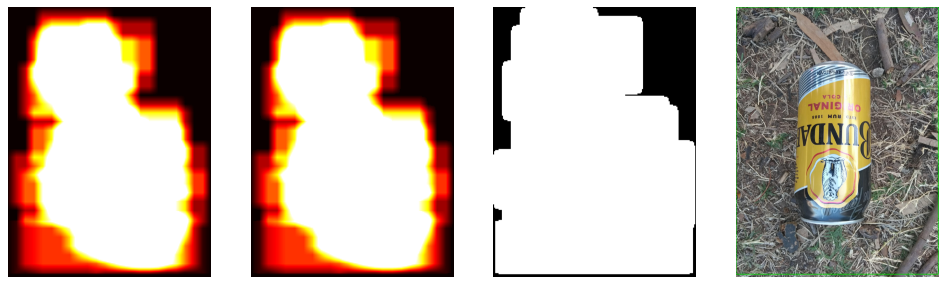

In [9]:
heatmap_test(img1, heatmap)

In [10]:
object_proposals = heatmap.get_final_bounding_boxes()
print(object_proposals)

[((0, 0), (3108, 4116))]


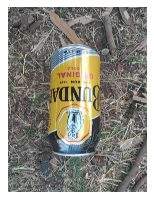

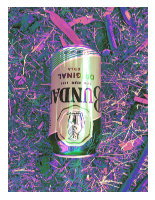

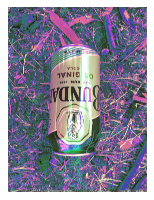

In [11]:
segmenter = WatershedSegmenter(img1, object_proposals)
show_images([img1], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
segmented_object_proposals = segmenter.segment_object_proposals()
show_images([segmented_object_proposals[0]], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
final_image= segmenter.build_final_image(segmented_object_proposals)
show_images([final_image], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)